In [1]:
import os
gpus = [1]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
import socket
import os
import sys
import pandas as pd
import scipy.io as sio
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import pylab
import h5py
import pickle
import seaborn as sns
import random
import collections
import logging
import datetime
import itertools
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import gc
import importlib
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("../..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *
from trainingfunctions import *

In [3]:
data_folder = os.path.abspath('/mnt/cube/kai/data_processed/bci/prelim_10_motif')
save_folder = os.path.abspath('/mnt/cube/kai/results/bci/prelim_10_motif')

# load data

In [4]:
input_output_df = pickle.load(open(os.path.join(data_folder, 'input_output_2021_04_23_06_38.p'), 'rb'))

In [5]:
input_output_df.tail()

,motif,step,input,output
1365,9,132,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[-0.34626780131000034, -0.6976743063570495, -0..."
1366,9,133,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.4414303893804583, -0.6573171533142144, -1...."
1367,9,134,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.45199486637298775, -0.6906773651003755, -0..."
1368,9,135,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.28211163644209253, -0.6644469578173456, -0..."
1369,9,136,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.2459257798562328, -0.7444524827126306, -0...."


In [6]:
n_motifs = len(input_output_df.motif.value_counts())
n_steps = len(input_output_df.step.value_counts())

In [7]:
n_lookbacks, n_clusters = input_output_df.input.values[0].shape

In [8]:
print(n_lookbacks, n_clusters)

10 73


In [9]:
n_specs = input_output_df.output.values[0].shape[0]

# model parameters

In [10]:
l2_val = 0.001
dropout_val = 0.2
num_neurons = [20, 30]

# training parameters

In [11]:
num_ep = 1000
patience = 50
early_stopping = True
valid_split = 0.1
batch_size = 10
n_parts = 10
mode = 'part_wise'

In [12]:
np.ceil(10/3).astype(int)

4

In [13]:
np.array(input_output_df[~input_output_df.motif.isin([4, 5])].input.values.tolist()).shape

(1096, 10, 73)

In [14]:
train_input, train_output, test_input, test_output = train_test_split(input_output_df, 10, 8, 'part_wise')

In [15]:
test_input.shape

(140, 10, 73)

# compile model

In [16]:
run_name = f'{datetime.datetime.now():%Y_%m_%d_%H_%M}'
run_folder = extend_folder(save_folder, run_name)
test_output_compiled = list()
test_prediction_compiled = list()
history_compiled = list()

for test_index in range(n_parts):
    index_folder = extend_folder(run_folder, str(test_index))
    train_input, train_output, test_input, test_output = train_test_split(input_output_df, n_parts, test_index, mode)
    
    # compile model
    model = Sequential()
    model.add(LSTM(num_neurons[0], input_shape = (n_lookbacks, n_clusters), return_sequences=True, 
                   kernel_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(LSTM(num_neurons[1], kernel_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(Dense(n_specs, kernel_regularizer=l2(l2_val)))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    model_file = os.path.join(index_folder, 'weights-improvement.h5')
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
                 ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]
    history = model.fit(train_input, train_output, epochs=num_ep, batch_size=batch_size, verbose=1, 
                        validation_split=valid_split, callbacks=callbacks)
    
    # reload model to measure prediction loss
    del model
    model = load_model(model_file)
    
    # plot loss and validation loss over epochs
    fig = plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.savefig(os.path.join(index_folder, 'learning curve.png'))
    plt.close(fig)
    
    # test prediction, save to a pickle file
    test_prediction = model.predict(test_input)
    rmse = [np.sqrt(np.mean(np.square(np.array(prediction)-np.array(original)))) for prediction, original in zip(test_prediction, test_output)]
    save_file = os.path.join(index_folder,'results.p' )
    results_df = pd.DataFrame()
    results_df['prediction'] = list(test_prediction)
    results_df['target'] = list(test_output)
    results_df['rmse'] = rmse
    results_df.to_pickle(save_file)
    
    
    history_compiled.append([history.history['loss'], history.history['val_loss']])
    test_output_compiled+=list(test_output)
    test_prediction_compiled+=list(test_prediction)
    paragraph_print('Data appended', separation='-')

pickle.dump([test_output_compiled, 
             test_prediction_compiled, history_compiled], open(os.path.join(run_folder, 'all_results.p'), 'wb'))

Epoch 1/1000
111/111 [==============================] - 2s 19ms/step - loss: 0.3482 - val_loss: 0.1203
Epoch 2/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.1041 - val_loss: 0.0824
Epoch 3/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0727 - val_loss: 0.0642
Epoch 4/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0568 - val_loss: 0.0553
Epoch 5/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0467 - val_loss: 0.0470
Epoch 6/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0413 - val_loss: 0.0447
Epoch 7/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0372 - val_loss: 0.0426
Epoch 8/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0341 - val_loss: 0.0393
Epoch 9/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0334 - val_loss: 0.0389
Epoch 10/1000
111/111 [==============================] - 1s 10ms/step - l

Data appended
--------------------------------------------------
Epoch 1/1000
111/111 [==============================] - 2s 16ms/step - loss: 0.3576 - val_loss: 0.1213
Epoch 2/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.1070 - val_loss: 0.0823
Epoch 3/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0740 - val_loss: 0.0645
Epoch 4/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0573 - val_loss: 0.0521
Epoch 5/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0474 - val_loss: 0.0467
Epoch 6/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0408 - val_loss: 0.0416
Epoch 7/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0372 - val_loss: 0.0405
Epoch 8/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0344 - val_loss: 0.0370
Epoch 9/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0330 - val_loss: 0.0373
Epoch 10/1000

111/111 [==============================] - 1s 8ms/step - loss: 0.0180 - val_loss: 0.0367
Epoch 80/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.0392
Epoch 81/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.0367
Epoch 82/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0176 - val_loss: 0.0370
Epoch 83/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0178 - val_loss: 0.0370
Epoch 84/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0176 - val_loss: 0.0371
Epoch 85/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0177 - val_loss: 0.0376
Epoch 86/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0175 - val_loss: 0.0387
Epoch 87/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0176 - val_loss: 0.0382
Epoch 88/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0177 - v

111/111 [==============================] - 1s 6ms/step - loss: 0.0195 - val_loss: 0.0411
Epoch 60/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0195 - val_loss: 0.0403
Epoch 61/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0195 - val_loss: 0.0395
Epoch 62/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0191 - val_loss: 0.0424
Epoch 63/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0191 - val_loss: 0.0395
Epoch 64/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0195 - val_loss: 0.0397
Epoch 65/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0192 - val_loss: 0.0402
Epoch 66/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0190 - val_loss: 0.0404
Epoch 67/1000
111/111 [==============================] - 1s 7ms/step - loss: 0.0191 - val_loss: 0.0396
Epoch 68/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0189 - v

111/111 [==============================] - 1s 8ms/step - loss: 0.0196 - val_loss: 0.0339
Epoch 69/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0193 - val_loss: 0.0349
Epoch 70/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0192 - val_loss: 0.0366
Epoch 71/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0195 - val_loss: 0.0343
Epoch 72/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0191 - val_loss: 0.0348
Epoch 73/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0192 - val_loss: 0.0350
Epoch 74/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0190 - val_loss: 0.0343
Epoch 75/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0188 - val_loss: 0.0358
Epoch 76/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0188 - val_loss: 0.0362
Epoch 77/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0188 - v

111/111 [==============================] - 1s 9ms/step - loss: 0.0204 - val_loss: 0.0396
Epoch 56/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0205 - val_loss: 0.0376
Epoch 57/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0204 - val_loss: 0.0393
Epoch 58/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0200 - val_loss: 0.0390
Epoch 59/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0204 - val_loss: 0.0386
Epoch 60/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0200 - val_loss: 0.0374
Epoch 61/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0198 - val_loss: 0.0399
Epoch 62/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0200 - val_loss: 0.0388
Epoch 63/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0198 - val_loss: 0.0389
Epoch 64/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0194 - v

111/111 [==============================] - 1s 8ms/step - loss: 0.0215 - val_loss: 0.0370
Epoch 43/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0211 - val_loss: 0.0369
Epoch 44/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0211 - val_loss: 0.0366
Epoch 45/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0210 - val_loss: 0.0361
Epoch 46/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0363
Epoch 47/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0209 - val_loss: 0.0364
Epoch 48/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0203 - val_loss: 0.0356
Epoch 49/1000
111/111 [==============================] - 1s 7ms/step - loss: 0.0201 - val_loss: 0.0385
Epoch 50/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0202 - val_loss: 0.0373
Epoch 51/1000
111/111 [==============================] - 1s 7ms/step - loss: 0.0203 - v

111/111 [==============================] - 1s 10ms/step - loss: 0.0144 - val_loss: 0.0375
Epoch 122/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0148 - val_loss: 0.0357
Epoch 123/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0143 - val_loss: 0.0383
Epoch 124/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0144 - val_loss: 0.0366
Epoch 125/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0141 - val_loss: 0.0363
Epoch 126/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0144 - val_loss: 0.0361
Epoch 127/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0367
Epoch 128/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0143 - val_loss: 0.0362
Epoch 129/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0141 - val_loss: 0.0382
Epoch 130/1000
111/111 [==============================] - 1s 10ms/step 

Epoch 9/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0334 - val_loss: 0.0384
Epoch 10/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0324 - val_loss: 0.0377
Epoch 11/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0314 - val_loss: 0.0366
Epoch 12/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0311 - val_loss: 0.0373
Epoch 13/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0302 - val_loss: 0.0377
Epoch 14/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0300 - val_loss: 0.0359
Epoch 15/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0299 - val_loss: 0.0370
Epoch 16/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0300 - val_loss: 0.0355
Epoch 17/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0296 - val_loss: 0.0361
Epoch 18/1000
111/111 [==============================] - 1s 10ms/step

111/111 [==============================] - 1s 9ms/step - loss: 0.0324 - val_loss: 0.0399
Epoch 10/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0312 - val_loss: 0.0391
Epoch 11/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0305 - val_loss: 0.0391
Epoch 12/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0299 - val_loss: 0.0384
Epoch 13/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0295 - val_loss: 0.0384
Epoch 14/1000
111/111 [==============================] - 1s 11ms/step - loss: 0.0293 - val_loss: 0.0391
Epoch 15/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0296 - val_loss: 0.0379
Epoch 16/1000
111/111 [==============================] - 1s 7ms/step - loss: 0.0286 - val_loss: 0.0384
Epoch 17/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0279 - val_loss: 0.0382
Epoch 18/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0278 -

111/111 [==============================] - 1s 9ms/step - loss: 0.0163 - val_loss: 0.0400
Epoch 89/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0165 - val_loss: 0.0394
Epoch 90/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0165 - val_loss: 0.0382
Epoch 91/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0163 - val_loss: 0.0376
Epoch 92/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0161 - val_loss: 0.0412
Epoch 93/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0163 - val_loss: 0.0381
Epoch 94/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0160 - val_loss: 0.0378
Epoch 95/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0158 - val_loss: 0.0402
Epoch 96/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0159 - val_loss: 0.0390
Epoch 97/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0163 - v

111/111 [==============================] - 1s 10ms/step - loss: 0.0216 - val_loss: 0.0402
Epoch 49/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0212 - val_loss: 0.0371
Epoch 50/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0215 - val_loss: 0.0386
Epoch 51/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0211 - val_loss: 0.0375
Epoch 52/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0210 - val_loss: 0.0391
Epoch 53/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0207 - val_loss: 0.0403
Epoch 54/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0389
Epoch 55/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0205 - val_loss: 0.0398
Epoch 56/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0208 - val_loss: 0.0393
Epoch 57/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0204 - 

111/111 [==============================] - 1s 9ms/step - loss: 0.0149 - val_loss: 0.0376
Epoch 128/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0150 - val_loss: 0.0383
Epoch 129/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0148 - val_loss: 0.0367
Epoch 130/1000
111/111 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.0367
Epoch 131/1000
111/111 [==============================] - 1s 6ms/step - loss: 0.0145 - val_loss: 0.0370
Epoch 132/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0364
Epoch 133/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0145 - val_loss: 0.0375
Epoch 134/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0145 - val_loss: 0.0379
Epoch 135/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0144 - val_loss: 0.0372
Epoch 136/1000
111/111 [==============================] - 1s 10ms/step - loss:

111/111 [==============================] - 1s 10ms/step - loss: 0.0132 - val_loss: 0.0367
Epoch 206/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0131 - val_loss: 0.0385
Epoch 207/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0132 - val_loss: 0.0369
Epoch 208/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0128 - val_loss: 0.0379
Epoch 209/1000
111/111 [==============================] - 1s 10ms/step - loss: 0.0130 - val_loss: 0.0378
Epoch 210/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0132 - val_loss: 0.0342
Epoch 211/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0127 - val_loss: 0.0363
Epoch 212/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0129 - val_loss: 0.0356
Epoch 213/1000
111/111 [==============================] - 1s 9ms/step - loss: 0.0136 - val_loss: 0.0357
Epoch 214/1000
111/111 [==============================] - 1s 9ms/step - lo

114/114 [==============================] - 1s 10ms/step - loss: 0.0219 - val_loss: 0.0406
Epoch 48/1000
114/114 [==============================] - 1s 10ms/step - loss: 0.0215 - val_loss: 0.0410
Epoch 49/1000
114/114 [==============================] - 1s 10ms/step - loss: 0.0217 - val_loss: 0.0427
Epoch 50/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0216 - val_loss: 0.0415
Epoch 51/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0212 - val_loss: 0.0399
Epoch 52/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0211 - val_loss: 0.0398
Epoch 53/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0210 - val_loss: 0.0400
Epoch 54/1000
114/114 [==============================] - 1s 8ms/step - loss: 0.0209 - val_loss: 0.0395
Epoch 55/1000
114/114 [==============================] - 1s 9ms/step - loss: 0.0203 - val_loss: 0.0392
Epoch 56/1000
114/114 [==============================] - 1s 10ms/step - loss: 0.0201

# recombine slices into specgrams

In [17]:
original_motifs = []
predicted_motifs = []
average_steps = np.ceil(n_steps/n_parts).astype(int)
for part in range(n_parts):
    steps_per_motif = int(train_test_split(input_output_df, n_parts, part, mode)[3].shape[0]/n_motifs)
    for motif_i in range(n_motifs):
        if len(original_motifs)<=motif_i:
            original_motifs.append([])
            predicted_motifs.append([])
        predicted_motifs[motif_i]+=test_prediction_compiled[average_steps*n_motifs*part+
                                                            steps_per_motif*motif_i:average_steps*n_motifs*part+steps_per_motif*(motif_i+1)]
        original_motifs[motif_i]+=test_output_compiled[average_steps*n_motifs*part+
                                                       steps_per_motif*motif_i:average_steps*n_motifs*part+steps_per_motif*(motif_i+1)]

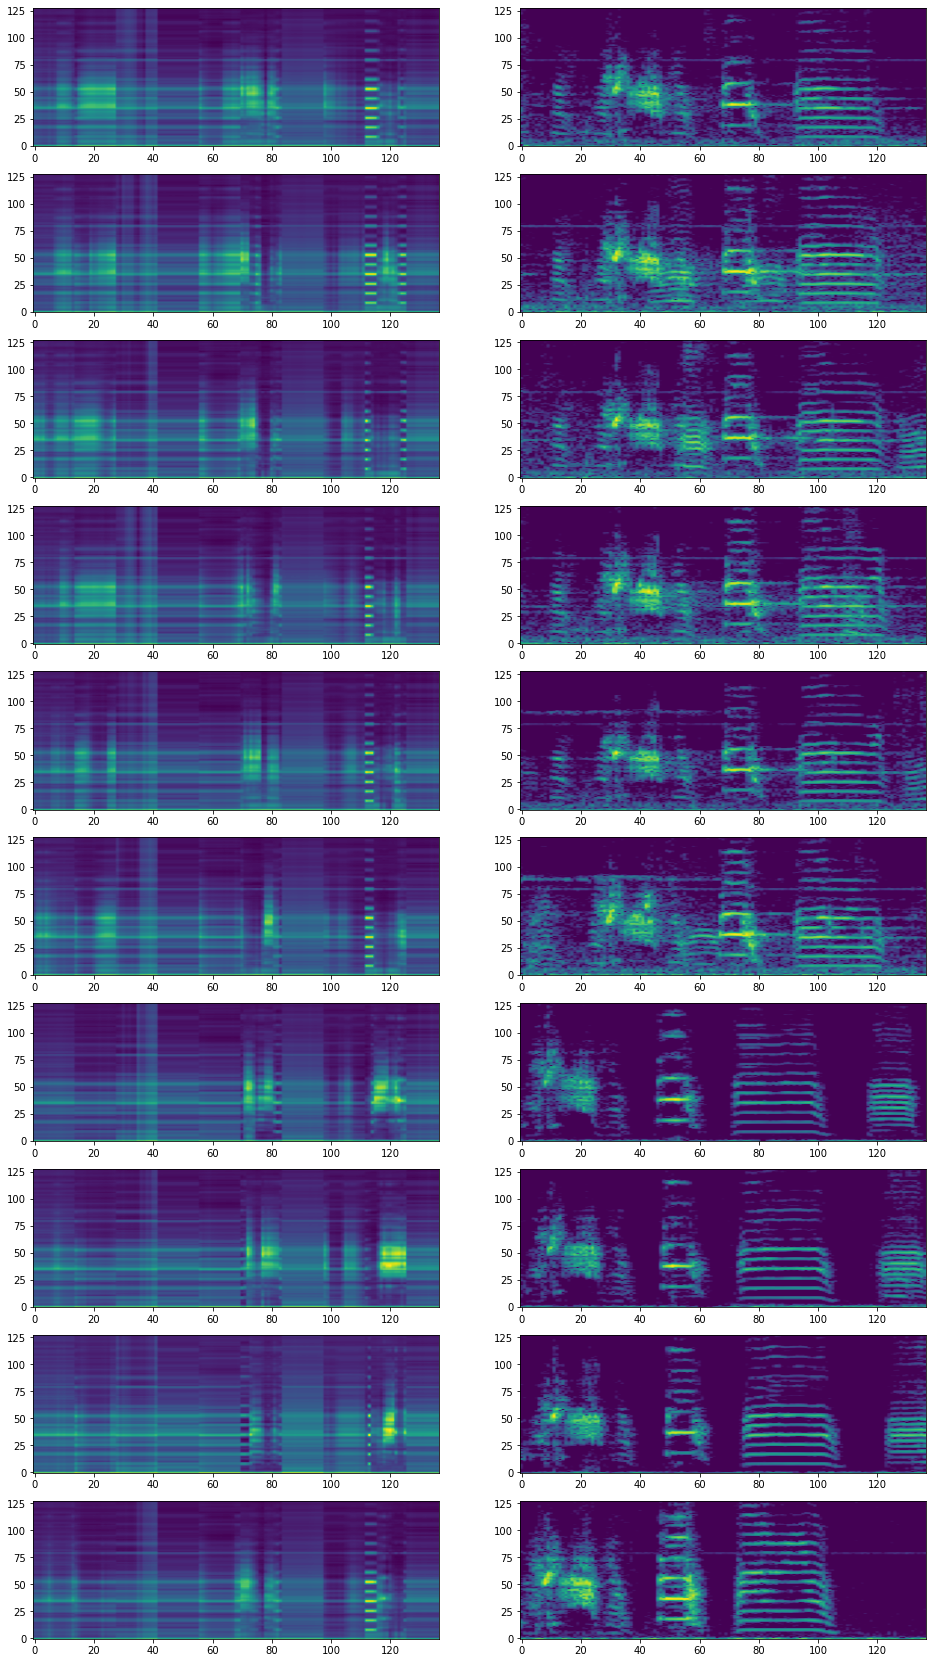

In [18]:
fig, ax = plt.subplots(10, 2, figsize=(16,30))
for i in range(n_motifs):
    ax[i][0].imshow(np.array(predicted_motifs[i]).T, origin='lower', aspect='auto')
    ax[i][1].imshow(np.array(original_motifs[i]).T, origin='lower', aspect='auto')